In [3]:
import os
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'DejaVu Sans' # - 폰트 깨짐 방지

In [4]:
data = pd.read_csv('10min_Averaged_BearingTest_Dataset.csv')
data['time'] = pd.to_datetime(data['time'], format='%Y-%m-%d %H:%M:%S')
data = data.set_index('time')

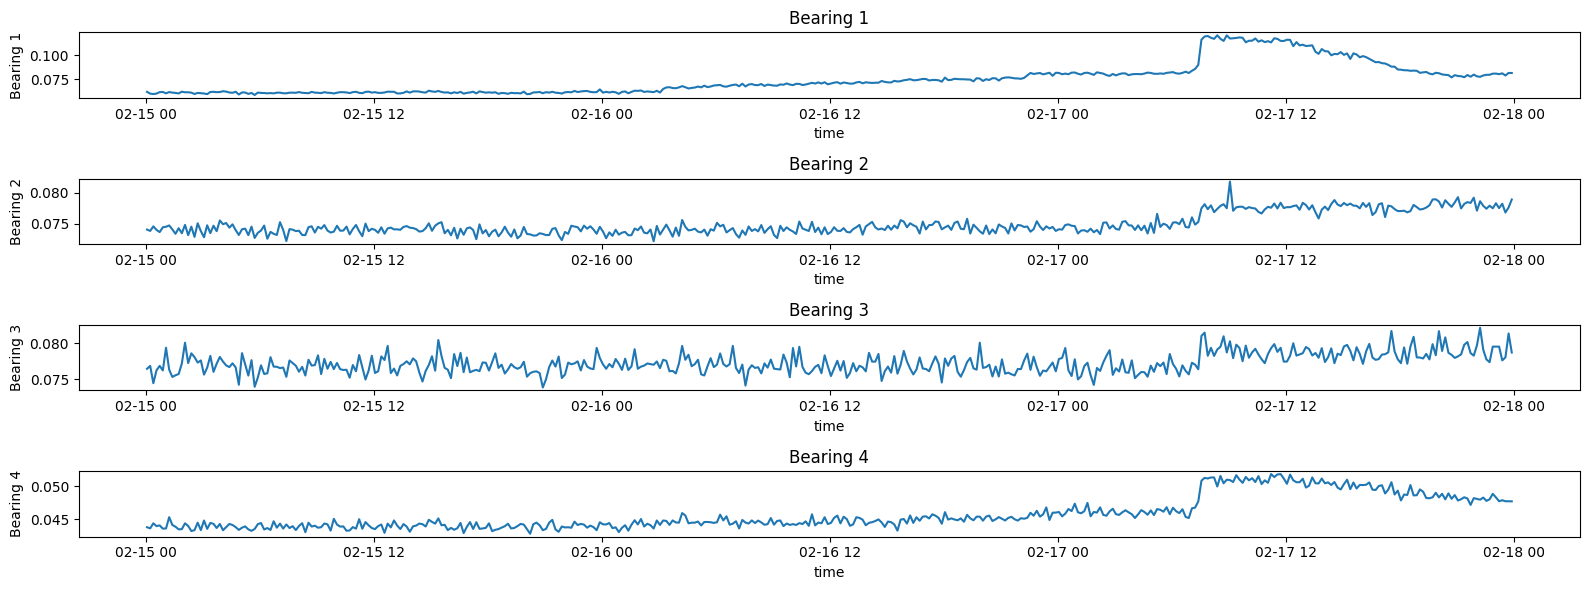

In [12]:
plt.figure(figsize=(16, 6))
for i, column in enumerate(data.columns):
    plt.subplot(4, 1, i + 1)
    sns.lineplot(x=data.loc['2004-02-15':'2004-02-17'].index, y=data.loc['2004-02-15':'2004-02-17'][column])
    plt.title(column)
plt.tight_layout()
plt.show()

- 16일부터 베어링 1은 변화. 베어링 4는 미세한 변화
- 17일부터 전체적으로 변화

In [5]:
train = data.loc[:'2004-02-15']
test = data.loc['2004-02-16':]

std = StandardScaler()
X_train_sc = std.fit_transform(train)
X_test_sc = std.transform(test)

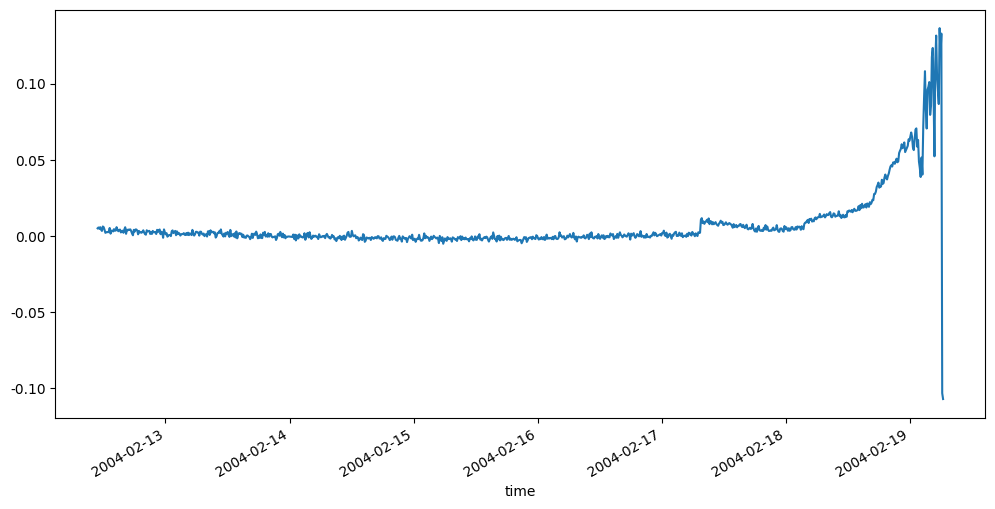

In [4]:
from sklearn.decomposition import PCA
 
pca = PCA(n_components=1, random_state=0)
x_train_pca = pd.DataFrame(pca.fit_transform(train))
x_train_pca.index = train.index
 
x_test_pca = pd.DataFrame(pca.transform(test))
x_test_pca.index = test.index
 
df_pca = pd.concat([x_train_pca, x_test_pca])
df_pca.plot(figsize = (12, 6))
plt.legend().remove()

<Axes: xlabel='time'>

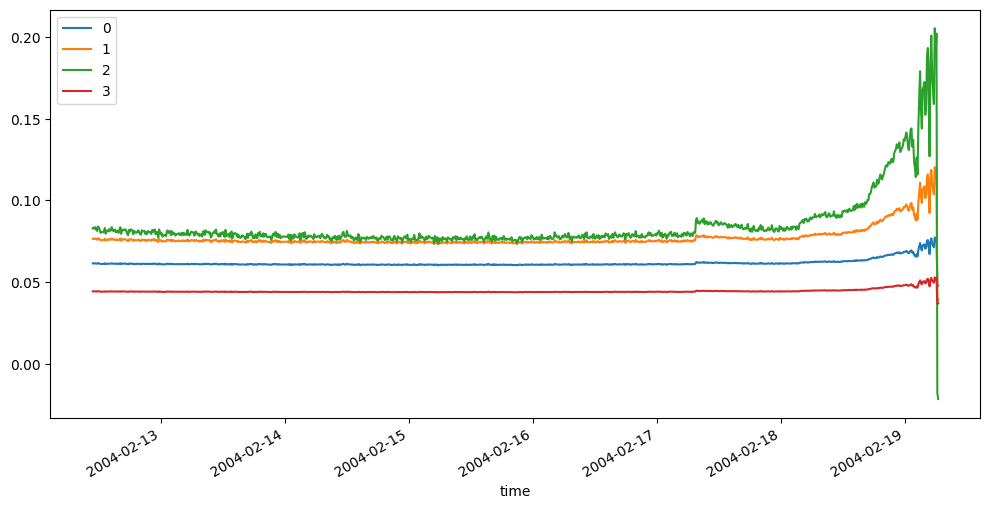

In [5]:
df_restored = pd.DataFrame(pca.inverse_transform(df_pca), index=df_pca.index)
df_restored.plot(figsize = (12, 6))

<Axes: xlabel='time'>

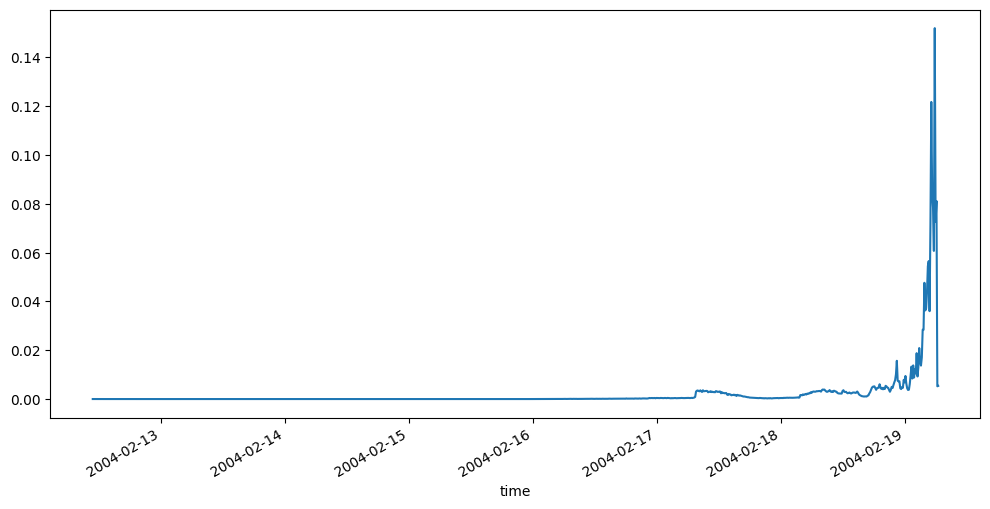

In [6]:
def get_anomaly_scores(df_original, df_restored):
    loss = np.sum((np.array(df_original) - np.array(df_restored)) ** 2, axis=1)
    loss = pd.Series(data=loss, index=df_original.index)
    return loss
 
scores = get_anomaly_scores(data, df_restored)
scores.plot(figsize = (12, 6))

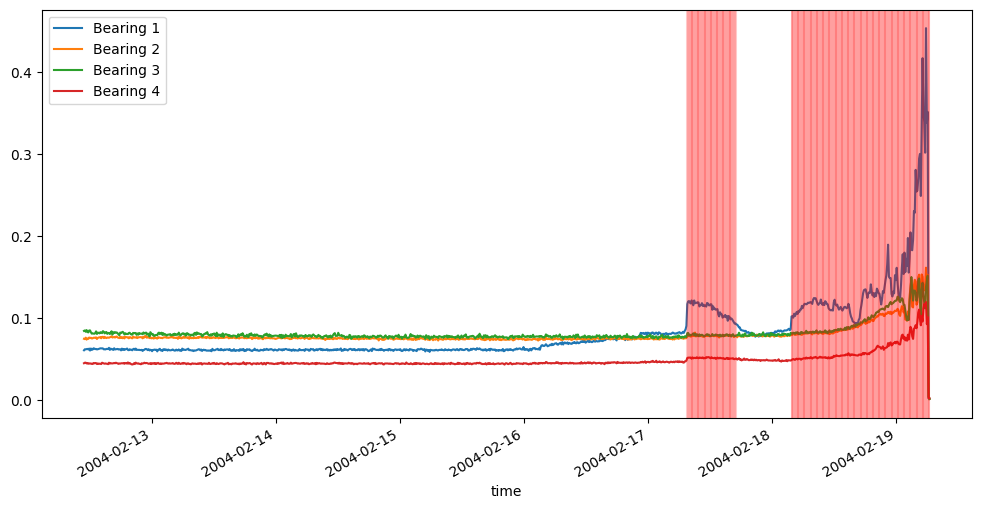

In [7]:
def is_anomaly(data, pca, threshold):
    pca_data = pca.transform(data)
    restored_data = pca.inverse_transform(pca_data)
    loss = np.sum((data - restored_data) ** 2)
    return loss > threshold

data.plot(figsize = (12, 6))
counts = 0 
for index, row in data.iterrows():
    if is_anomaly([row], pca, 0.001):
        plt.axvline(row.name, color='r', alpha=0.2)
        counts += 1

# Isolation

In [66]:
from sklearn.ensemble import IsolationForest

# IsolationForest 모델 학습 (anomaly는 -1, normal은 1로 표현되므로, y 값을 조정)
model = IsolationForest(contamination=0.001, max_features=0.1, max_samples=30, n_estimators=100, random_state=42)
model.fit(train)

# 예측 (-1, 1 값을 1, 0으로 변환)
pred_train = model.predict(train)
pred_test = model.predict(test)
y_pred_train = [1 if pred == -1 else 0 for pred in pred_train]
y_pred_test = [1 if pred == -1 else 0 for pred in pred_test]

In [67]:
pred1 = pd.DataFrame(y_pred_train)
pred2 = pd.DataFrame(y_pred_test)
pred = pd.concat([pred1, pred2], axis=0)
df = data.reset_index()
pred.index = df.index
df = pd.concat([df, pred], axis=1)
df.set_index('time', inplace=True)
# tmp = df[0]
# df.drop(0, axis=1, inplace=True)
# tmp

<Figure size 1600x500 with 0 Axes>

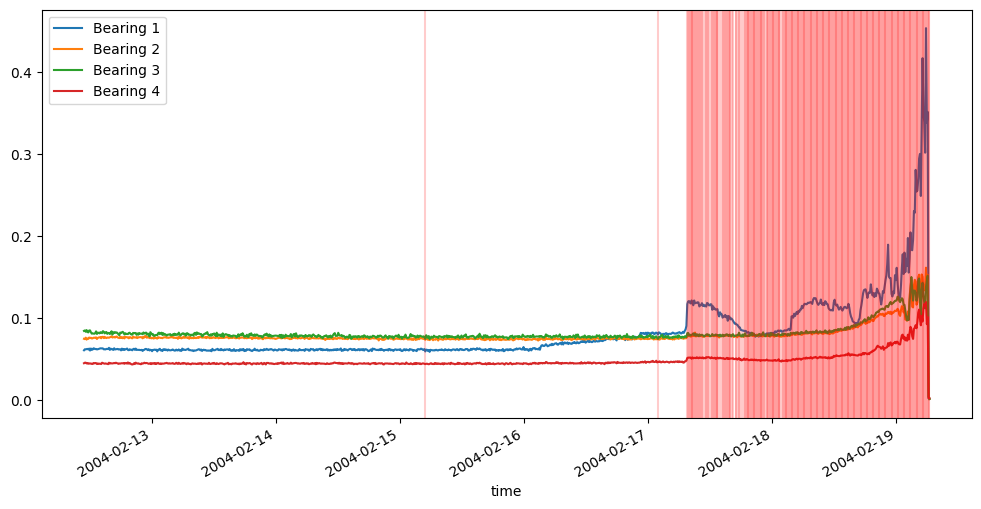

In [69]:
plt.figure(figsize=(16,5))

# 예를 들어, 'value'라는 열을 y로 사용하고자 한다면:
data.plot(figsize=(12,6))

# 빨간색 선을 그리기 위해 anomaly가 1인 인덱스를 반복합니다.
for idx in df[df[0]==1].index:
    plt.axvline(x=idx, color='red', alpha=0.2)

plt.show()


In [24]:
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Model

n_features = X_train_sc.shape[1]
latent_dim = 2  # 더 높은 latent_dim을 사용하여 더 많은 정보 압축

# 인코더
enc_inputs = layers.Input(shape=(n_features,))
x = layers.Dense(32, activation='relu')(enc_inputs)
x = layers.Dense(16, activation='relu')(x)
x = layers.Dense(8, activation='relu')(x)
x = layers.Dense(2, activation='relu')(x)
enc_outputs = layers.Dense(latent_dim, activation='relu')(x) # Latent vector

encoder = Model(inputs=enc_inputs, outputs=enc_outputs)

# 디코더
dec_inputs = layers.Input(shape=(latent_dim,)) # Latent vector
x = layers.Dense(2, activation='relu')(dec_inputs)
x = layers.Dense(8, activation='relu')(x)
x = layers.Dense(16, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)
dec_outputs = layers.Dense(n_features, activation='sigmoid')(x) # 데이터를 보고 거기에 맞춰서 활성화 함수 사용 

decoder = Model(inputs=dec_inputs, outputs=dec_outputs)

# 오토인코더
inputs = layers.Input(shape=(n_features,))
latent = encoder(inputs)
outputs = decoder(latent)

AE = Model(inputs=inputs, outputs=outputs)
AE.compile(optimizer='adam', loss='binary_crossentropy', metrics='acc') # 오차 구하는 것 중에 미분이 잘 되는 것 mse
AE.summary()


Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 4)]               0         
                                                                 
 model_18 (Functional)       (None, 2)                 848       
                                                                 
 model_19 (Functional)       (None, 4)                 850       
                                                                 
Total params: 1,698
Trainable params: 1,698
Non-trainable params: 0
_________________________________________________________________


In [25]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=200, restore_best_weights=True)

history = AE.fit(X_train_sc,X_train_sc, validation_split=0.2, batch_size=128, epochs=50, callbacks=[early_stopping]) # 압축 후 복원하기 때문에, 자신과 비교

Epoch 1/50
4/4 [==============================] - 0s 43ms/step - loss: 0.6916 - acc: 0.2990 - val_loss: 0.6837 - val_acc: 0.0000e+00
Epoch 2/50
4/4 [==============================] - 0s 18ms/step - loss: 0.6845 - acc: 0.2745 - val_loss: 0.6715 - val_acc: 0.0000e+00
Epoch 3/50
4/4 [==============================] - 0s 16ms/step - loss: 0.6763 - acc: 0.2745 - val_loss: 0.6559 - val_acc: 0.0000e+00
Epoch 4/50
4/4 [==============================] - 0s 18ms/step - loss: 0.6656 - acc: 0.2745 - val_loss: 0.6354 - val_acc: 0.0000e+00
Epoch 5/50
4/4 [==============================] - 0s 8ms/step - loss: 0.6533 - acc: 0.2745 - val_loss: 0.6086 - val_acc: 0.0000e+00
Epoch 6/50
4/4 [==============================] - 0s 8ms/step - loss: 0.6362 - acc: 0.2745 - val_loss: 0.5732 - val_acc: 0.0000e+00
Epoch 7/50
4/4 [==============================] - 0s 8ms/step - loss: 0.6173 - acc: 0.2745 - val_loss: 0.5259 - val_acc: 0.0000e+00
Epoch 8/50
4/4 [==============================] - 0s 8ms/step - loss: 0.

In [8]:
p_test = AE.predict(test)
p_test.shape

15/15 [==============================] - 0s 997us/step


(471, 4)

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
time,,,,
2004-02-16 00:02:39,0.060751,0.073686,0.077033,0.044211
2004-02-16 00:12:39,0.061643,0.072594,0.076426,0.044189
2004-02-16 00:22:39,0.060911,0.073555,0.077088,0.044403
2004-02-16 00:32:39,0.061637,0.072990,0.076635,0.043632
2004-02-16 00:42:39,0.061124,0.073986,0.077780,0.043753
...,...,...,...,...
2004-02-19 05:42:39,0.453335,0.161016,0.137440,0.119047
2004-02-19 05:52:39,0.337583,0.132400,0.144992,0.092125
2004-02-19 06:02:39,0.351111,0.152266,0.151299,0.100817
